# Decision Tree

### Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_testing_fake.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

### Model Training and In-Sample Fitting

Best parameters for horizon 1:  {'max_depth': 5}


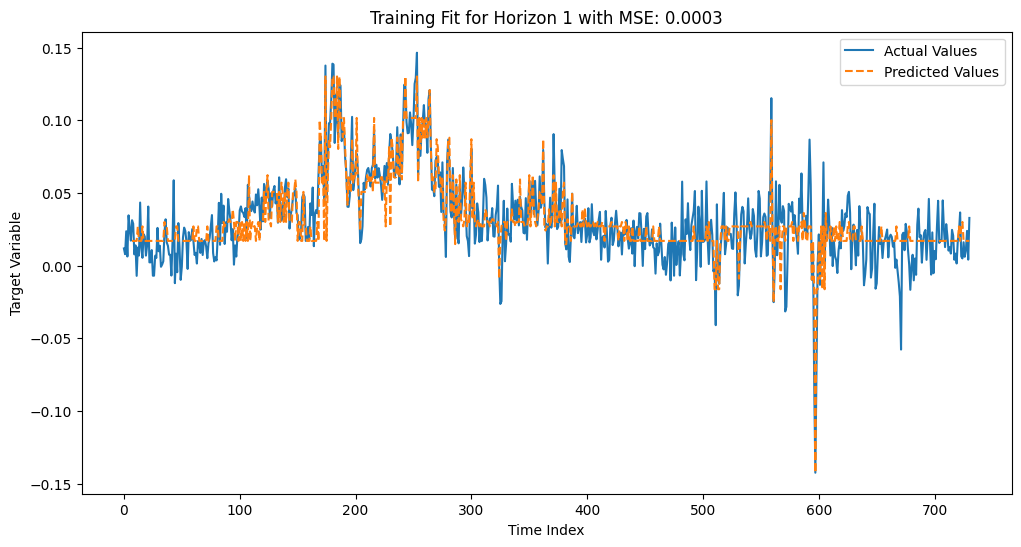

Best parameters for horizon 3:  {'max_depth': 6}


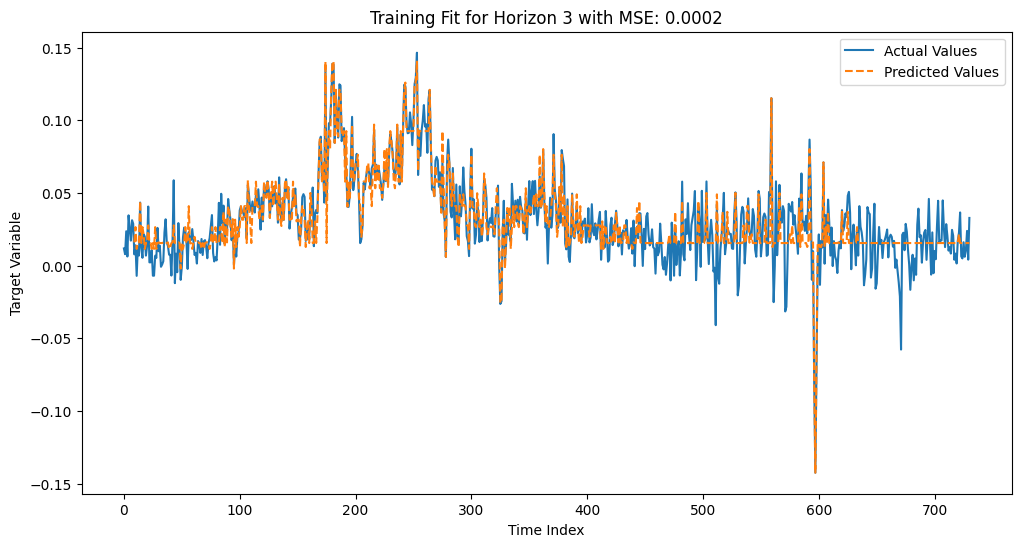

Best parameters for horizon 12:  {'max_depth': 6}


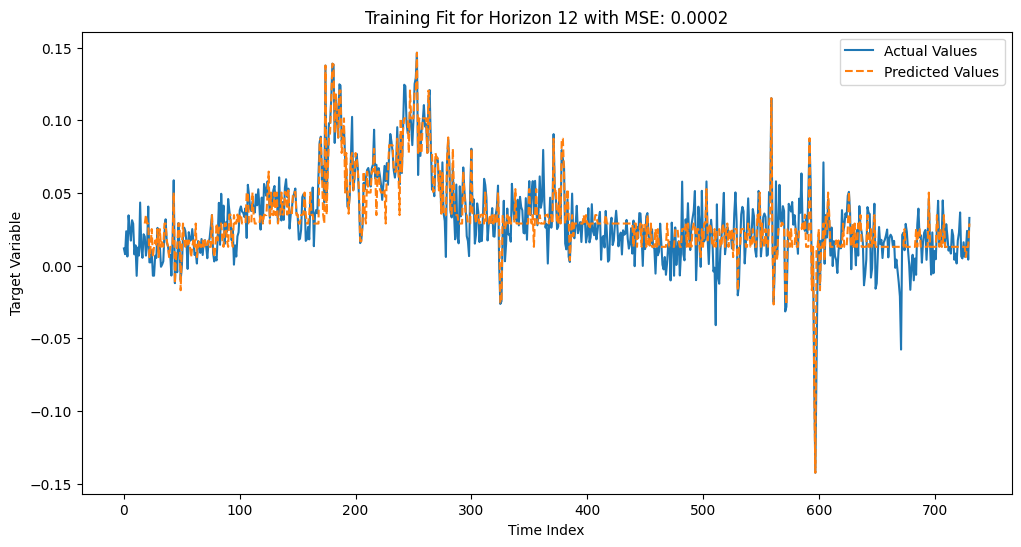

In [14]:
def prepare_data(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
        feature_set = features.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged predictor features
        target_lags = target.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged values of the target variable  
        X.append(np.hstack([feature_set, target_lags]))
        # Append the actual target value for the corresponding time point 'i' to the target list
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

param_grid = {'max_depth': range(5, 10)}

n_lags=6
horizons = [1, 3, 12]
models_tree = {}
best_params = {}

for horizon in horizons:
    X, y = prepare_data(train_predictors, train_inflation_rate, n_lags, horizon)
    model_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=tscv)
    model_tree.fit(X, y)
    models_tree[horizon] = model_tree.best_estimator_
    best_params[horizon] = model_tree.best_params_
    
    print(f"Best parameters for horizon {horizon}: ", model_tree.best_params_)

    y_train_pred = model_tree.predict(X)
    train_mse = mean_squared_error(y, y_train_pred)

    # Visualize the fit on the training set
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_train_pred)), y_train_pred, label='Predicted Values', linestyle='--')
    plt.title(f"Training Fit for Horizon {horizon} with MSE: {train_mse:.4f}")
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

### Pseudo Out-of-Sample Prediction

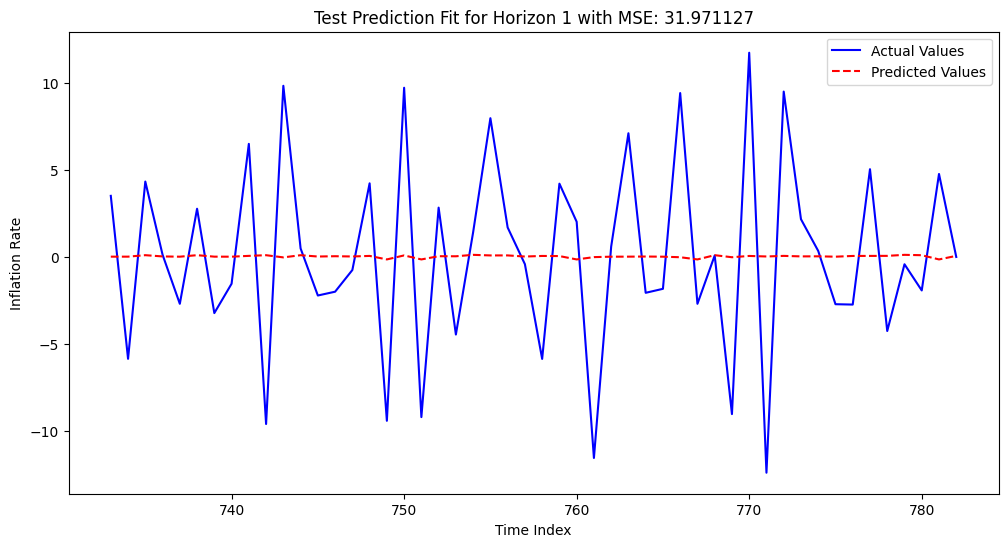

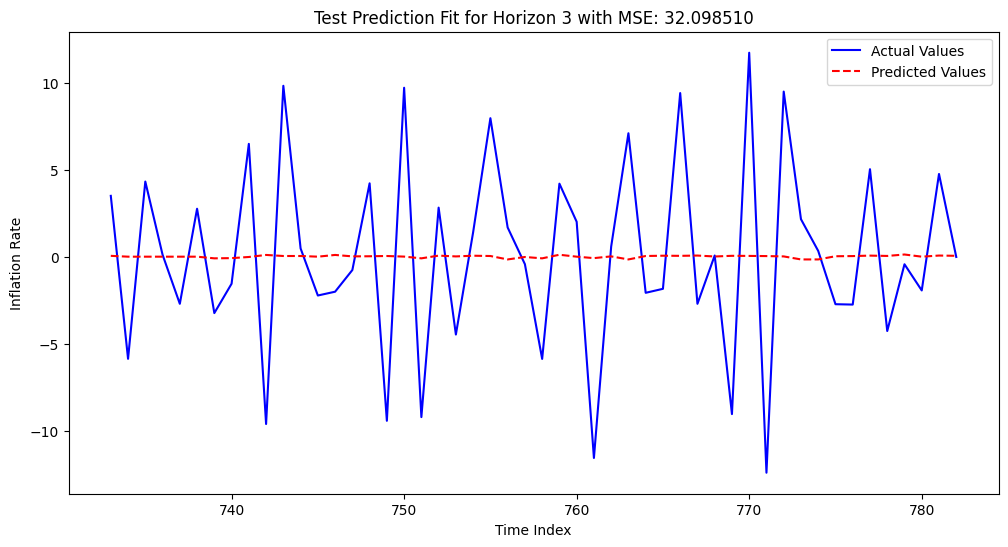

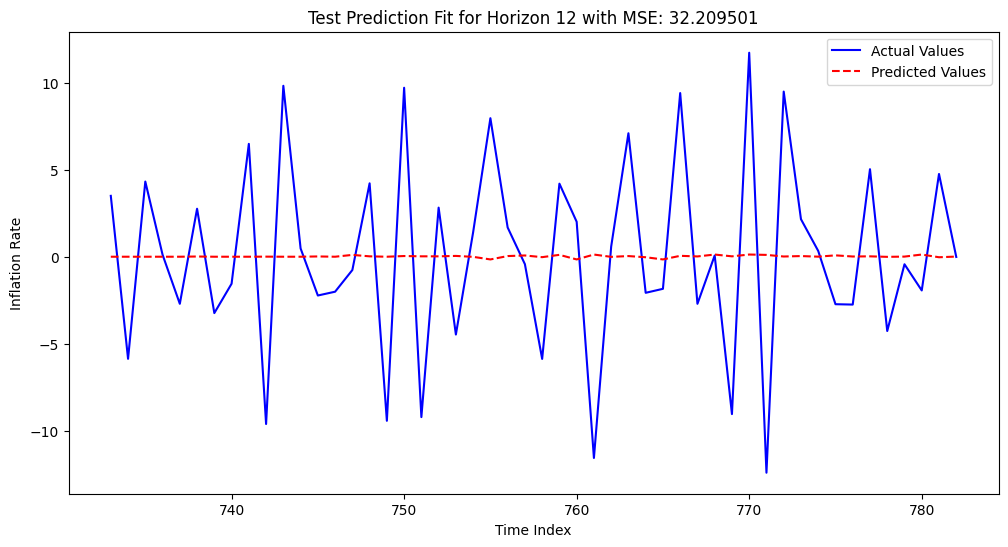

In [15]:
def prepare_test_data(train_features, train_target, test_features, test_target, n_lags, horizon):
    # Extend test features by including sufficient training set tail data to handle lag and horizon
    combined_features = pd.concat([train_features.iloc[-(n_lags + horizon):], test_features])
    combined_target = pd.concat([train_target.iloc[-(n_lags + horizon):], test_target])
    
    X_test, y_test = [], []
    # Start index is after the initial n_lags + horizon to form a complete first set of features
    start_index = n_lags + horizon

    # Iterate through combined data to form feature and target sets for testing
    for i in range(start_index, len(combined_target)):
        start_idx = i - n_lags - horizon
        end_idx = i - horizon
        # Flatten feature sets to create a single array per sample
        feature_set = combined_features.iloc[start_idx:end_idx].to_numpy().flatten()
        target_lags = combined_target.iloc[start_idx:end_idx].to_numpy().flatten()
        
        X_test.append(np.hstack([feature_set, target_lags]))
        y_test.append(combined_target.iloc[i])

    return np.array(X_test), np.array(y_test)

test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model_tree = models_tree[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_tree.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()